# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


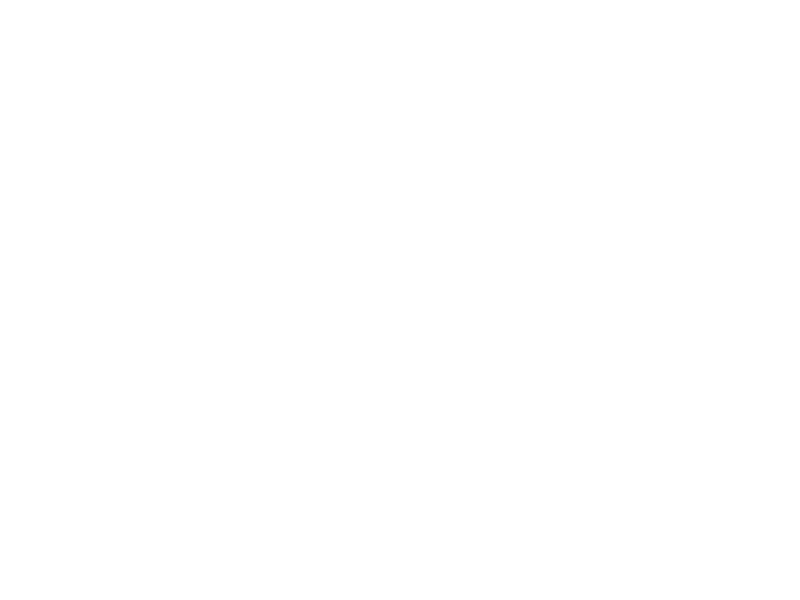

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


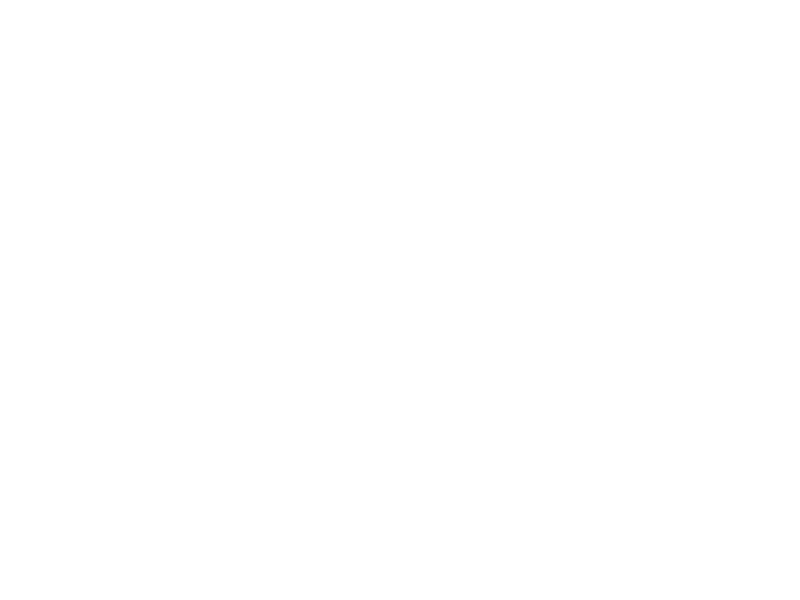

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


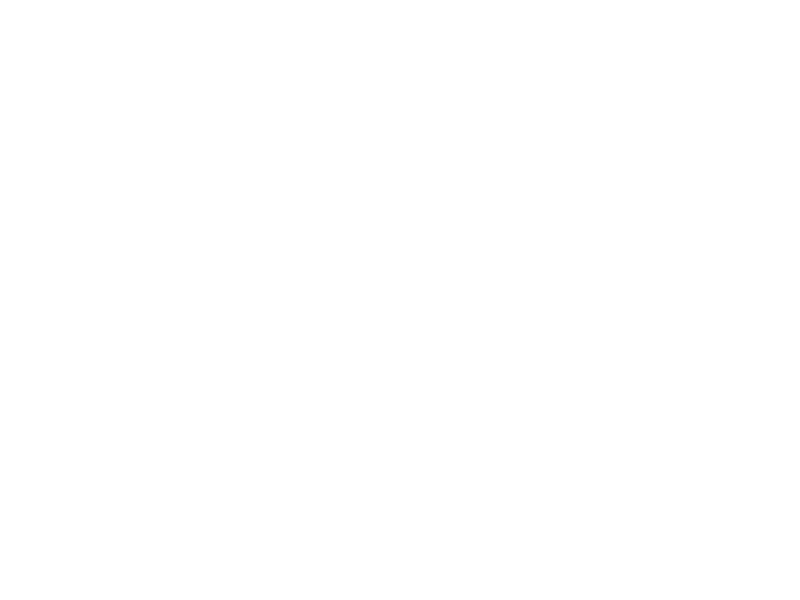

In [5]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


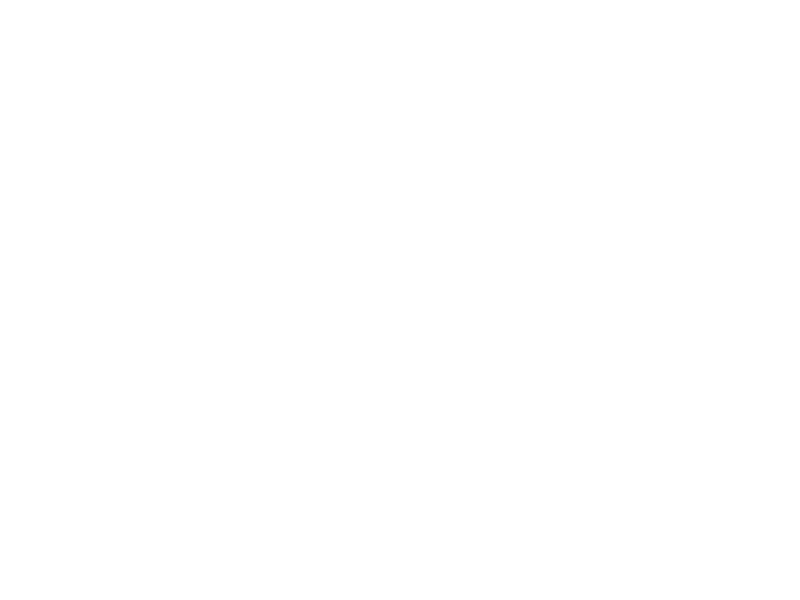

In [6]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Implementacja drzewa

In [7]:
def getLineYInX(line, x):
    t = (x - line[0][0]) / (line[1][0] - line[0][0])
    return line[0][1] + t * (line[1][1] - line[0][1])


def cmpLines(toInsert, otherLine):
    return toInsert[0][1] < getLineYInX(otherLine, toInsert[0][0])


class Node:
    def __init__(self, line):
        self.line = line
        self.height = 0
        self.parent = None
        self.left = None
        self.right = None


class SweepBST:
    def __init__(self):
        self.linesDict = dict()
        self.root = None

    def findLowest(self):
        node = self.root
        if node is None:
            return None
        while node.left is not None:
            node = node.left
        return node

    def printTreeInOrder(self):
        node = self.findLowest()
        while node is not None:
            print(node.line)
            node = self.findNext(node)

    def swap(self, line1, line2):
        node1 = self.linesDict[tuple(line1)]
        node2 = self.linesDict[tuple(line2)]
        tmp = node1.line
        node1.line = node2.line
        node2.line = tmp

        self.linesDict[tuple(line1)] = node2
        self.linesDict[tuple(line2)] = node1

    def setRoot(self, node):
        self.root = node

    def insert(self, line):
        if self.root is None:
            self.setRoot(Node(line))
            self.linesDict[tuple(line)] = self.root
            return self.root
        else:
            node = self.insertNode(self.root, line)
            self.linesDict[tuple(line)] = node
            return node

    def insertNode(self, currentNode, line):
        if cmpLines(line, currentNode.line):
            if currentNode.left is not None:
                inserted = self.insertNode(currentNode.left, line)
                if self.getBalance(currentNode) < -1:
                    if cmpLines(line, currentNode.left.line):
                        self.rotateRight(currentNode)
                    else:
                        self.rotateLeft(currentNode.left)
                        self.rotateRight(currentNode)
            else:
                currentNode.left = Node(line)
                currentNode.left.parent = currentNode
                return currentNode.left
        else:
            if currentNode.right is not None:
                inserted = self.insertNode(currentNode.right, line)
                if self.getBalance(currentNode) > 1:
                    if not cmpLines(line, currentNode.left.line):
                        self.rotateLeft(currentNode)
                    else:
                        self.rotateRight(currentNode.right)
                        self.rotateLeft(currentNode)
            else:
                currentNode.right = Node(line)
                currentNode.right.parent = currentNode
                return currentNode.right
        return inserted
    
    def find(self, line):
        return self.linesDict[tuple(line)]

    def findNext(self, node):
        if node is None:
            return None

        if node.right is not None:
            node = node.right
            while node.left is not None:
                node = node.left
            return node

        while node.parent is not None and node == node.parent.right:
            node = node.parent

        return node.parent

    def findPrev(self, node):
        if node is None:
            return None

        if node.left is not None:
            node = node.left
            while node.right is not None:
                node = node.right
            return node

        while node.parent is not None and node == node.parent.left:
            node = node.parent

        return node.parent

    def removeNode(self, node):
        if self.root is node:
            if node.left is None and node.right is None:
                self.setRoot(None)
            elif node.left is None:
                self.setRoot(node.right)
                self.root.parent = None
            elif node.right is None:
                self.setRoot(node.left)
                self.root.parent = None
            else:
                succ = self.findNext(node)
                self.removeNode(succ)
                node.line = succ.line
                self.linesDict[tuple(node.line)] = node
            actual = None

        elif node.left is None and node.right is None:
            if node == node.parent.right:
                node.parent.right = None
            else:
                node.parent.left = None
            actual = node.parent

        elif node.left is None:
            node.right.parent = node.parent
            if node == node.parent.right:
                node.parent.right = node.right
            else:
                node.parent.left = node.right
            actual = node.parent

        elif node.right is None:
            node.left.parent = node.parent
            if node == node.parent.right:
                node.parent.right = node.left
            else:
                node.parent.left = node.left
            actual = node.parent
        
        else:
            succ = self.findNext(node)
            self.removeNode(succ)
            node.line = succ.line
            self.linesDict[tuple(node.line[0])] = node
            actual = node.parent
                
        while actual is not None:
            balance = self.getBalance(actual)
            nextAct = actual.parent

            # Case 1,2 - Left 
            if balance < -1:
                #Left
                if self.getBalance(actual.left) <= 0: 
                    self.rightRotate(actual)
                #Right
                else:
                    self.leftRotate(actual.left) 
                    self.rightRotate(actual)
                    
            # Case 3,4 - Right 
            if balance > 1:
                #Right
                if self.getBalance(actual.right) >= 0: 
                    self.leftRotate(actual) 
                #Left
                else:
                    self.rightRotate(actual.right) 
                    self.leftRotate(actual)  
            actual = nextAct
        
        return node

    def remove(self, line):
        node = self.find(line)
        node = self.removeNode(node)
        del self.linesDict[tuple(line)]
        return node

    #Rotations from https://www.geeksforgeeks.org/avl-tree-set-1-insertion/
    def leftRotate(self, z):

        y = z.right
        T2 = y.left

        if self.root == z:
            self.setRoot(y)
        else:
            if z == z.parent.left:
                z.parent.left = y
            else:
                z.parent.right = y

        # Perform rotation 
        y.left = z
        z.right = T2

        T2.parent = z
        y.parent = z.parent
        z.parent = y

        # Update heights
        z.height = 1 + max(self.getHeight(z.left),
                           self.getHeight(z.right))
        y.height = 1 + max(self.getHeight(y.left),
                           self.getHeight(y.right))

    def rightRotate(self, z):

        y = z.left
        T3 = y.right

        if self.root == z:
            self.setRoot(y)
        else:
            if z == z.parent.left:
                z.parent.left = y
            else:
                z.parent.right = y
            
        # Perform rotation 
        y.right = z
        z.left = T3
        
        T3.parent = z
        y.parent = z.parent
        z.parent = y

        # Update heights 
        z.height = 1 + max(self.getHeight(z.left),
                           self.getHeight(z.right))
        y.height = 1 + max(self.getHeight(y.left),
                           self.getHeight(y.right))

    def getHeight(self, root):
        if not root:
            return -1
        return root.height

    def getBalance(self, root):
        if not root:
            return 0

        return self.getHeight(root.right) - self.getHeight(root.left) 



### Operacje wektorowe

In [8]:
import math

def vectorsAdd(u, v):
    return (u[0] + v[0], u[1] + v[1])

def vectorsSubtract(u, v):
    return (u[0] - v[0], u[1] - v[1])
    
def vectorsProduct(u, v):
    return u[0]*v[1] - u[1]*v[0]

def vectorScale(a, u):
    return (a*u[0], a*u[1])

def vectorNorm(u):
    return math.sqrt(u[0]**2 + u[1]**2)

def vectorsDistance(u, v):
    return vectorNorm(vectorsSubtract(u,v))

### Akcje do podjęcia

In [9]:
#returns (intersectionPoint, line1, line2) or None
def checkIntersect(line1, line2, epsilon=10**(-12)):
    if line1[0][0] < line2[0][0]:
        tmp = line1
        line1 = line2
        line2 = tmp
    
    p = line1[0]
    r = vectorsSubtract(line1[1], line1[0])
    
    q = line2[0]
    s = vectorsSubtract(line2[1], line2[0])
    
    rxs = vectorsProduct(r,s)
    if abs(rxs) < epsilon:
        return None
    
    qpDiff = vectorsSubtract(q,p)
    
    t = vectorsProduct(qpDiff, s)/rxs
    u = vectorsProduct(qpDiff, r)/rxs
    
    if t >= 0 and t <= 1 and u >= 0 and u <= 1:
        return (vectorsAdd(p, vectorScale(t,r)), (line1, line2))
    else:
        return None

def checkPrev(T, node):
    pr = T.findPrev(node)
    if pr is not None:
        return checkIntersect(node.line, pr.line)
    else:
        return None

def checkNext(T, node):
    ne = T.findNext(node)
    if ne is not None:
        return checkIntersect(node.line, ne.line)
    else:
        return None
    
def checkNeibours(T, node):
    inter1 = checkPrev(T, node)
    inter2 = checkNext(T, node)
    toReturn = []
    if inter1 is not None:
        toReturn.append(inter1)
    if inter2 is not None:
        toReturn.append(inter2)
    return toReturn if toReturn else None
    
def lineBegin(T, line):
    node = T.insert(line)
    return checkNeibours(T, node)
    
def lineEnd(T, line):
    node = T.find(line)
    n1 = T.findPrev(node)
    n2 = T.findNext(node)
    inter = None
    toReturn = None
    if n1 is not None and n2 is not None:
        inter = checkIntersect(n1.line, n2.line)
    if inter is not None:
        toReturn = [inter]
    T.remove(line)
    return toReturn
    
def intersection(T, line1, line2):
    T.swap(line1, line2)
    node1 = T.find(line1)
    node2 = T.find(line2)
    inter1 = checkNeibours(T, node1)
    inter2 = checkNeibours(T, node2)
    toReturn = []
    if inter1 is not None:
        toReturn += inter1
    if inter2 is not None:
        toReturn += inter2
    return toReturn if toReturn else None

### Algorytm zamiatania szukający jednego przecięcia

In [10]:
from queue import PriorityQueue

#action consts
A_BEGIN = 0
A_END = 1
A_INTERSECT = 2

#returns (intersectionPoint, (line1, line2))
def anyLinesIntersect(lines):
    Q = PriorityQueue()
    T = SweepBST()
    for l in lines:
        l.sort(key=lambda point: point[0])
        Q.put((l[0][0], (A_BEGIN, l)))
        Q.put((l[1][0], (A_END, l)))
    while not Q.empty():
        (_, (action, line)) = Q.get()
        inter = None
        if action == A_BEGIN:
            inter = lineBegin(T, line)
        if action == A_END:
            inter = lineEnd(T, line)
        if inter is not None:
            return inter[0]
            
def printIntersect(inter):
    if inter is not None:
        (point, (line1, line2)) = inter   
        print("Intersection Point: " + str(point))
        print("\t1. Line: " + str(line1))
        print("\t2. Line: " + str(line2))
    else:
        print("No intersection")

### Algorytm zamiantania znajdujący wszystkie przecięcia

In [11]:
#Takes argument linesToCheck (list of lines)
#Returns list of intersections in format (point, [line1, line2])
def sweepingAlg(linesToCheck):
    #Event queue of tuples (x_coordinate, (action_to_take, list_of_lines))
    Q = PriorityQueue()
    
    #Binary search tree storing lines sorted by y coordinates
    T = SweepBST()
    
    #Dictionary of intersections to avoid finding same intersection multiple times
    intersDict = dict()
    
    for l in linesToCheck:
        #Sorting points in every line by x coordinate to find line begin and end
        l.sort(key=lambda point: point[0])
        
        #Putting new events in the event queue
        Q.put((l[0][0], (A_BEGIN, [l])))
        Q.put((l[1][0], (A_END, [l])))
        
    while not Q.empty():
        (_, (action, lines)) = Q.get()
        inters = None
        if action == A_BEGIN:
            inters = lineBegin(T, lines[0])
        if action == A_END:
            inters = lineEnd(T, lines[0])
        if action == A_INTERSECT:
            inters = intersection(T, lines[0], lines[1])
        if inters is not None:
            for (point, intLines) in inters:
                if point not in intersDict:
                    Q.put((point[0], (A_INTERSECT, [intLines[0], intLines[1]])))
                    intersDict[point] = intLines
    toReturn = []
    for t in intersDict.items():
        toReturn.append(t)
    return toReturn

### Algorytm zamiatania z wizualizacją

In [12]:
def sweepingAlgWithScenes(linesToCheck, scenes):
    Q = PriorityQueue()
    T = SweepBST()
    intersDict = dict()
    
    eventsColl = [PointsCollection([], color = "orange")]
    linesColl = [LinesCollection(linesToCheck)]
    processedColl = []
    
    sweepMax = -float('inf')
    sweepMin = float('inf')
    for l in linesToCheck:
        l.sort(key=lambda point: point[0])
        
        sweepMax = max(sweepMax, max(l, key = lambda point: point[1])[1])
        sweepMin = min(sweepMin, min(l, key = lambda point: point[1])[1])
        
        Q.put((l[0][0], (A_BEGIN, [l])))
        Q.put((l[1][0], (A_END, [l])))
        eventsColl[0].add_points(l)
    
    scenes.append(Scene(eventsColl.copy(), linesColl.copy()))
    sweeps = []
        
    while not Q.empty():
        (_, (action, lines)) = Q.get()
        inters = None
        
        if action == A_BEGIN:
            inters = lineBegin(T, lines[0])
            sweepingPoint = lines[0][0]
        if action == A_END:
            inters = lineEnd(T, lines[0])
            sweepingPoint = lines[0][1]
        if action == A_INTERSECT:
            inters = intersection(T, lines[0], lines[1])
            sweepingPoint = checkIntersect(lines[0], lines[1])[0]
        
        sweeps.insert(0, LinesCollection([[(sweepingPoint[0],sweepMin),(sweepingPoint[0],sweepMax)]], color = "green"));
        scenes.append(Scene(eventsColl.copy() + processedColl.copy(),
                            linesColl.copy() + [sweeps[0]]))
        processedColl.append(PointsCollection([sweepingPoint], color = "red"))
        
        if inters is not None:
            for (point, intLines) in inters:
                if point not in intersDict:
                    eventsColl.append(PointsCollection([point], color = "orange"))
                    Q.put((point[0], (A_INTERSECT, [intLines[0], intLines[1]])))
                    intersDict[point] = intLines
        scenes.append(Scene(eventsColl.copy() + processedColl.copy(),linesColl.copy() + [sweeps[0]]))
    
    toReturn = []
    for t in intersDict.items():
        toReturn.append(t)
    return toReturn

### Funkcja wyświetlająca znalezione przecięcia

In [13]:
#Takes list of intersections in format (point, [line1, line2])
#Optionally shows lines which intersect, when showLines = True
def showSweepingResult(resList, showLines = True):
    print("Intersections found: " + str(len(resList)) + "\n")
    if showLines:
        for inter in resList:
            printIntersect(inter)
    else:
        for (point, _) in resList:
            print("Intersection Point: " + str(point))

### Usuwanie nielegalnych odcinków

In [14]:
def deleteVerticalSegments(lines, epsilon = 10**(-12)):
    i = 0
    l = len(lines)
    while i < l:
        if abs(lines[i][0][0] - lines[i][1][0]) < epsilon:
            del lines[i]
            l -= 1
        else:
            i += 1

### Interaktywne dodawanie odcinków

<IPython.core.display.Javascript object>


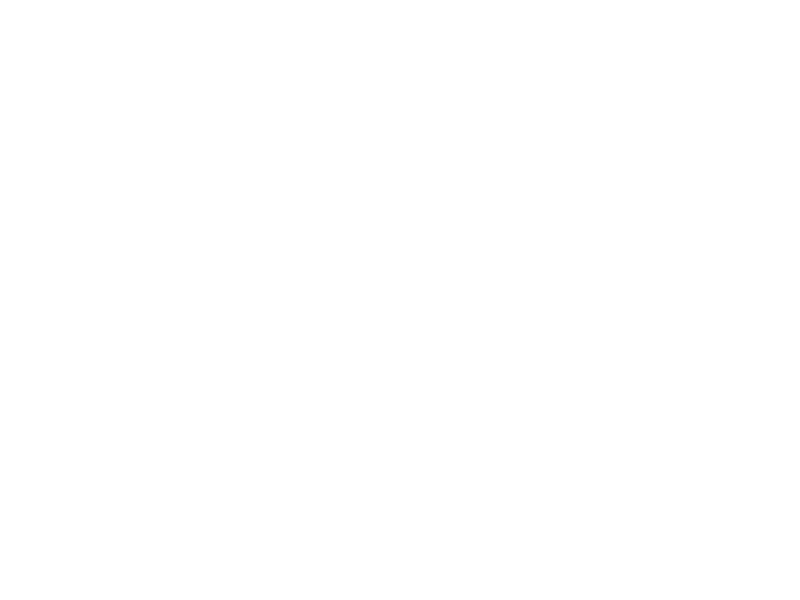

In [15]:
addingPlot = Plot()
addingPlot.draw()

In [16]:
EPSILON = 10**(-12)
myLines = addingPlot.get_added_lines()[0].lines
deleteVerticalSegments(myLines)

IndexError: list index out of range

In [17]:
scenes = []
resList = sweepingAlgWithScenes(myLines, scenes)
plot = Plot(scenes)
plot.draw()
showSweepingResult(resList)

NameError: name 'myLines' is not defined

### Funkcja generująca losowe odcinki

In [18]:
import random

def randPoint(lowerLeft, upperRight):
    return (random.uniform(lowerLeft[0], upperRight[0]), random.uniform(lowerLeft[1], upperRight[1]))

def randSegments(count, lowerLeft = (0,0), upperRight = (1,1), epsilon = 10**(-12)):
    lines = []
    for i in range(count):
        correct = False
        while not correct:
            point1 = randPoint(lowerLeft,upperRight)
            point2 = randPoint(lowerLeft,upperRight)
            correct = True
            if abs(point1[0] - point2[0]) < epsilon:
                correct = False
            elif vectorsDistance(point1, point2) < epsilon:
                correct = False
            else:
                for l in lines:
                    if vectorsDistance(l[0], point1) < epsilon:
                        correct = False
                    elif vectorsDistance(l[1], point1) < epsilon:
                        correct = False
                    elif vectorsDistance(l[0], point2) < epsilon:
                        correct = False
                    elif vectorsDistance(l[1], point2) < epsilon:
                        correct = False            
        lines.append([point1, point2])
    return lines

In [19]:
randLines = randSegments(10, (0,0), (20,20))

<IPython.core.display.Javascript object>


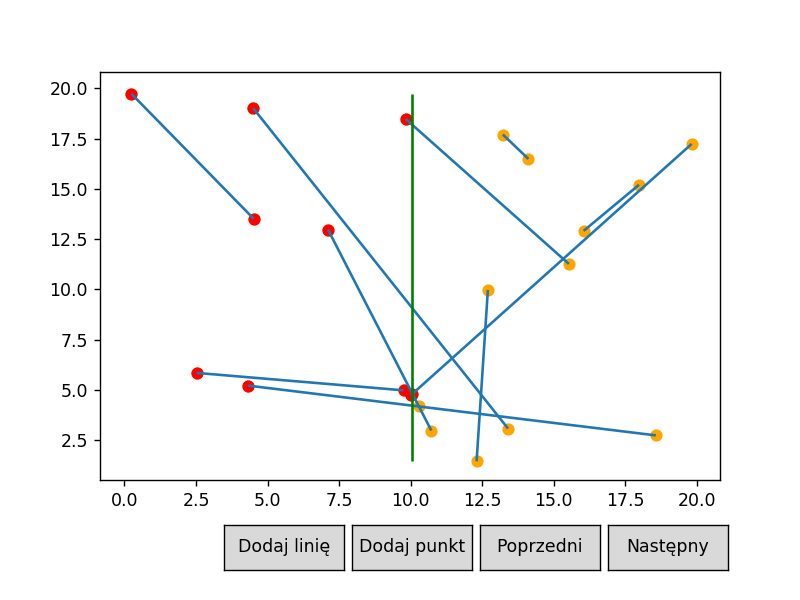

Intersections found: 3

Intersection Point: (10.288313730763685, 4.1817416683610436)
	1. Line: [(7.111102038654698, 12.975663872471978), (10.721450982909248, 2.9828995173861683)]
	2. Line: [(4.315701704764665, 5.219500724389303), (18.56730734797049, 2.7432419694593024)]
Intersection Point: (10.061091019860195, 4.810651239497024)
	1. Line: [(10.007249088922624, 4.742086625616686), (19.818939094880676, 17.236711633626147)]
	2. Line: [(7.111102038654698, 12.975663872471978), (10.721450982909248, 2.9828995173861683)]
Intersection Point: (12.456902194175052, 4.7751839846260475)
	1. Line: [(12.302932935062355, 1.4544983706003478), (12.698011890422285, 9.975244726259234)]
	2. Line: [(4.493943972624759, 19.02011395985603), (13.40198501771141, 3.084526032204058)]


In [20]:
randScenes = []
resList = sweepingAlgWithScenes(randLines, randScenes)
randPlot = Plot(randScenes)
randPlot.draw()
showSweepingResult(resList)

### Funkcja zapisująca do pliku .JSON

In [ ]:
def linesToJson(lines, fileName):
    with open(fileName + ".json", "w") as file:
        file.write(Plot([Scene([], [LinesCollection(lines)])]).toJson())

In [ ]:
linesToJson(myLines, "example")

### Funkcja wczytująca z pliku .JSON

In [ ]:
def linesFromJson(fileName):
    with open(fileName + ".json", 'r') as file:
        json = file.read()
    toReturn = []
    pl = Plot(json=json)
    for s in pl.scenes:
        for lcoll in s.lines:
            for l in lcoll.lines:
                toReturn.append([tuple(l[0]), tuple(l[1])])
    deleteVerticalSegments(toReturn)
    return toReturn

In [ ]:
ex1 = linesFromJson("example1")
ex2 = linesFromJson("example2")
ex3 = linesFromJson("example3")

In [ ]:
ex1scenes = []
ex1result = sweepingAlgWithScenes(ex1, ex1scenes)
ex1plot = Plot(ex1scenes)
ex1plot.draw()
showSweepingResult(ex1result)

In [ ]:
ex2scenes = []
ex2result = sweepingAlgWithScenes(ex2, ex2scenes)
ex2plot = Plot(ex2scenes)
ex2plot.draw()
showSweepingResult(ex2result)

In [ ]:
ex3scenes = []
ex3result = sweepingAlgWithScenes(ex3, ex3scenes)
ex3plot = Plot(ex3scenes)
ex3plot.draw()
showSweepingResult(ex3result)

In [ ]:
print("Example 1:")
printIntersect(anyLinesIntersect(ex1))
print("\nExample 2:")
printIntersect(anyLinesIntersect(ex2))
print("\nExample 3:")
printIntersect(anyLinesIntersect(ex3))